In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats as ss
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import pickle
import os
import scipy
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
plt.rc('text', usetex = True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,xcolor,siunitx}')

%matplotlib inline

# Data from Ouwens 2020

In [2]:
s2 = pd.read_excel('../data/41431_2019_511_MOESM2_ESM.xlsx', sheet_name=None)

[(k, v.shape) for k,v in s2.items()]

[('Sheet1', (51, 3)), ('allresults_2019-05-12', (52844, 48))]

In [3]:
h2 = s2['allresults_2019-05-12'].query(
    '''
    gene_biotype=="protein_coding" & \
    zerocounts_in_MZ <= (918-780) & \
    zerocounts_in_DZ <= (300-255) & \
    raw_median_count_per_gene > 10 & \
    N_SNPS > 20
    '''
).copy()

# add some stuff to Ouwens' df
h2['GCTA_Frac'] = h2['GCTA_VG2ofVp'] / h2['GCTA_Sum']
h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$']] = h2[['cis_eqtl_beta', 'trans_eqtl_beta']] ** 2
h2[r'$h^2_{cis}/h^2$'] = [f if not np.isnan(beta) else np.nan for _,(f,beta) in h2[['GCTA_Frac','cis_eqtl_beta']].iterrows()]

display(h2.shape, h2.columns, h2.head())

display(h2[[r'$\beta^2_{cis}$', r'$\beta^2_{trans}$', 'GCTA_Frac', r'$h^2_{cis}/h^2$']].describe())

ouwens_h2_cis = h2[r'$h^2_{cis}/h^2$'].dropna().values

(11409, 52)

Index(['GENE', 'raw_mean_count_per_gene', 'raw_median_count_per_gene',
       'residualized_mean_count_per_gene',
       'residualized_median_count_per_gene', 'zerocounts_in_DZ',
       'zerocounts_in_MZ', 'zerocounts_in_all', 'falconer_h2', 'MZcorrelation',
       'DZcorrelation', 'ACE_A', 'ACE_C', 'ACE_E', 'ACE_AICc', 'AE_A', 'AE_E',
       'AE_AICc', 'ACE_CE_Pvalue', 'GCTA_VG1ofVp', 'GCTA_VG1ofVP_SE',
       'GCTA_VG2ofVp', 'GCTA_VG2ofVp_SE', 'GCTA_Sum', 'GCTA_Sum_SE', 'N_SNPS',
       'hgnc_symbol', 'chromosome_name', 'start_position', 'end_position',
       'ensembl_transcript_id', 'gene_biotype', 'cis_eqtl_chromosome',
       'cis_eqtl_SNP', 'cis_eqtl_bp', 'cis_eqtl_effect_allele',
       'cis_eqtl_non_affect_allele', 'cis_eqtl_beta', 'cis_eqtl_P',
       'cis_eqtl_FDR', 'trans_eqtl_chromosome', 'trans_eqtl_SNP',
       'trans_eqtl_bp', 'trans_eqtl_effect_allele',
       'trans_eqtl_non_affect_allele', 'trans_eqtl_beta', 'trans_eqtl_P',
       'trans_eqtl_FDR', 'GCTA_Frac', '$\be

,GENE,raw_mean_count_per_gene,raw_median_count_per_gene,residualized_mean_count_per_gene,residualized_median_count_per_gene,zerocounts_in_DZ,zerocounts_in_MZ,zerocounts_in_all,falconer_h2,MZcorrelation,...,trans_eqtl_bp,trans_eqtl_effect_allele,trans_eqtl_non_affect_allele,trans_eqtl_beta,trans_eqtl_P,trans_eqtl_FDR,GCTA_Frac,$\beta^2_{cis}$,$\beta^2_{trans}$,$h^2_{cis}/h^2$
0,ENSG00000000419,133.743537,130.906235,1.180238e-18,-0.008395,0,0,0,-0.197863,0.106157,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011544,NaN,NaN,NaN
1,ENSG00000000457,124.870722,123.678165,2.059187e-18,-0.008612,0,0,0,0.165453,0.092706,...,169751853.0,T,C,-0.215534,2.440030e-08,4.036602e-07,0.717255,0.076627,0.046455,0.717255
2,ENSG00000000460,57.516552,56.681662,3.698310e-18,-0.012563,0,0,0,0.357618,0.335635,...,169580717.0,C,T,-0.272360,3.471390e-10,7.216771e-09,0.878784,0.380575,0.074180,0.878784
3,ENSG00000000938,13099.475192,12631.371927,-1.336965e-18,0.015804,0,0,0,0.397230,0.368861,...,NaN,NaN,NaN,NaN,NaN,NaN,0.043470,NaN,NaN,NaN
4,ENSG00000000971,20.054503,16.879363,3.629941e-18,-0.009700,3,6,12,0.561934,0.485259,...,NaN,NaN,NaN,NaN,NaN,NaN,0.010867,NaN,NaN,NaN


,$\beta^2_{cis}$,$\beta^2_{trans}$,GCTA_Frac,$h^2_{cis}/h^2$
count,5902.000000,5902.000000,11353.000000,5886.000000
mean,0.265897,0.132362,0.204536,0.335554
std,0.366534,0.203661,0.232011,0.225782
min,0.026803,0.024794,0.000001,0.000003
25%,0.073347,0.046914,0.028383,0.153760
50%,0.142890,0.072513,0.114606,0.280070
75%,0.324170,0.133108,0.306585,0.474463
max,7.492373,5.847836,0.999996,0.999996


# Synthetic Networks

Uses data from directed scale-free DAGs.

In [4]:
# load data from this file -- grn stub is for the path to the networks themselves
grn_file = 'figdata/dsfg.graphs.parquet'

grn_stub = os.path.join(
    os.path.dirname(grn_file),
    'graphs',
    os.path.splitext(os.path.basename(grn_file))[0]
)

grns = pd.read_parquet(grn_file)


# define some convenience variables
n_sims = grns.shape[0]
n_genes = grns['n'].iloc[0]

grns['Median '+r'$V_{cis}/V_{G}$'] = grns['Median '+r'$V_{cis}/V_{tot}$']
grns[r'$V_{cis}/V_{G}$'] = grns[r'$V_{cis}/V_{tot}$']

if 'ppm' in grn_file:
    grns['d'] = 1
grns['y'] = grns['Median '+r'$V_{cis}/V_{G}$']
grns['log_d'] = np.log(grns['d'])
grns[r'$r \gamma^2$'] = grns['r'] * (grns['gamma'] ** 2)

display(grns.head())

,model,n,r,k,d,gamma,p_up,hier,w,m,$V_{cis}/V_{tot}$,$max(B_{trans}^2/V_{cis})$,triangles,diamonds,Median $V_{cis}/V_{tot}$,Median $V_{cis}/V_{G}$,$V_{cis}/V_{G}$,y,log_d,$r \gamma^2$
0,dsfg,5000,5.425033,55,2.032283,0.308603,0.423356,False,33.545004,0.383174,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[8.881784197001244e-16, 2.436135136536793e-29,...",5338,16739,0.582176,0.582176,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.582176,0.709160,0.516657
1,dsfg,5000,4.123642,37,19.513432,0.377517,0.901563,False,145.183981,0.801307,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.778...","[4.440892098500624e-16, 1.630107104929357e-30,...",3440,7340,0.358481,0.358481,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.778...",0.358481,2.971103,0.587697
2,dsfg,5000,6.016103,79,11.148670,0.314075,0.177089,False,408.232486,0.839583,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[2.1573443450584817e-31, 2.0135717939190173e-3...",15771,37077,0.596487,0.596487,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.596487,2.411320,0.593449
3,dsfg,5000,8.279217,55,4.411394,0.302969,0.070393,False,17.297478,0.242610,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.915...","[2.6645352591003686e-15, 4.884981308350665e-15...",10263,54124,0.433683,0.433683,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.915...",0.433683,1.484191,0.759949
4,dsfg,5000,5.967968,65,1.131192,0.447152,0.570080,False,59.219359,0.480601,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.2604358664862946e-30, 1.1546319456101495e-1...",8061,22041,0.290483,0.290483,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.290483,0.123272,1.193265


## A reminder:

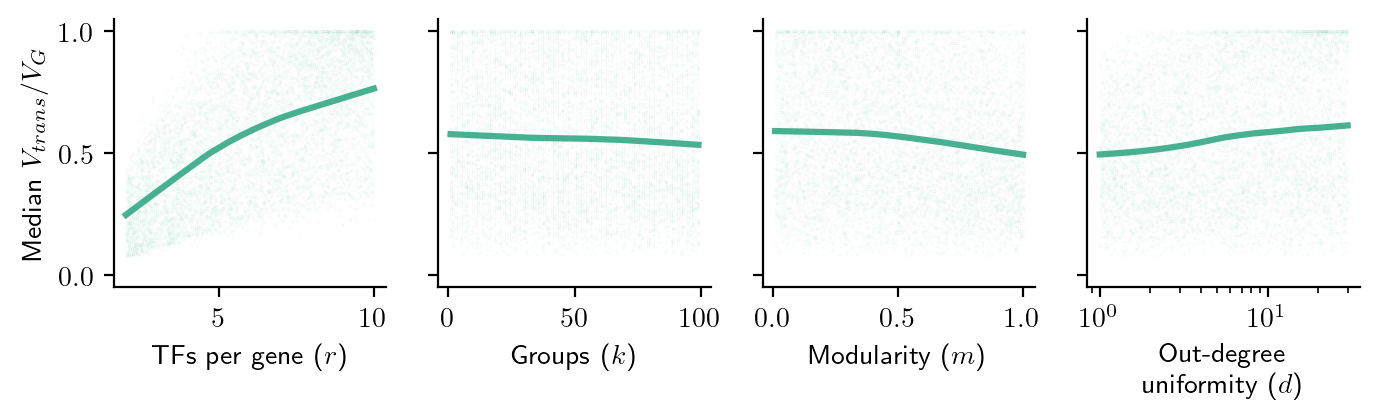

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(7, 2.2), dpi=200)

axs = axs.reshape(1,-1)

grns['Median '+r'$V_{trans}/V_{G}$'] = 1 - grns['Median '+r'$V_{cis}/V_{G}$']

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                np.array(['r','k','m','d']),
                                np.array([
                                 'TFs per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Out-degree\nuniformity ({})'.format(r'$d$')
                                 ])):
    ax = axs[ix, iy]
    for i, b in enumerate([0]):
        sns.regplot(data = grns.loc[(grns['hier']==b)], 
                    x = par, 
                    y = 'Median '+r'$V_{trans}/V_{G}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    x_ci = 'sd',
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=1e-3, alpha=0.2, label=None),
                    ax = ax
                   )
    ax.set_ylim(-0.05, 1.05);
    ax.set_xlabel(label);
    if iy != 0:
        ax.set_ylabel('');
        ax.set_yticklabels(['' for _ in ax.get_xticklabels()]);
    if par in ['d','w']:
        ax.set_xscale('log');
    if ix == 0 and iy == 9:
        ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

## Assess some summary stats

First, compute some summary stats and see how they're related

In [6]:
grns['Median ' + r'$max(B_{trans}^2/V_{cis})$'] = (
    grns[r'$max(B_{trans}^2/V_{cis})$'] / grns[r'$V_{cis}/V_{G}$']).apply(lambda x: np.median(x)).clip(upper=1)

grns['90Q ' + r'$max(B_{trans}^2/V_{cis})$'] = (
    grns[r'$max(B_{trans}^2/V_{cis})$'] / grns[r'$V_{cis}/V_{G}$']).apply(lambda x: np.quantile(x, 0.9)).clip(upper=1)

grns['Mean ' + r'$max(B_{trans}^2/V_{cis})$'] = (
    grns[r'$max(B_{trans}^2/V_{cis})$'] / grns[r'$V_{cis}/V_{G}$']).apply(lambda x: np.mean(x)).clip(upper=1)

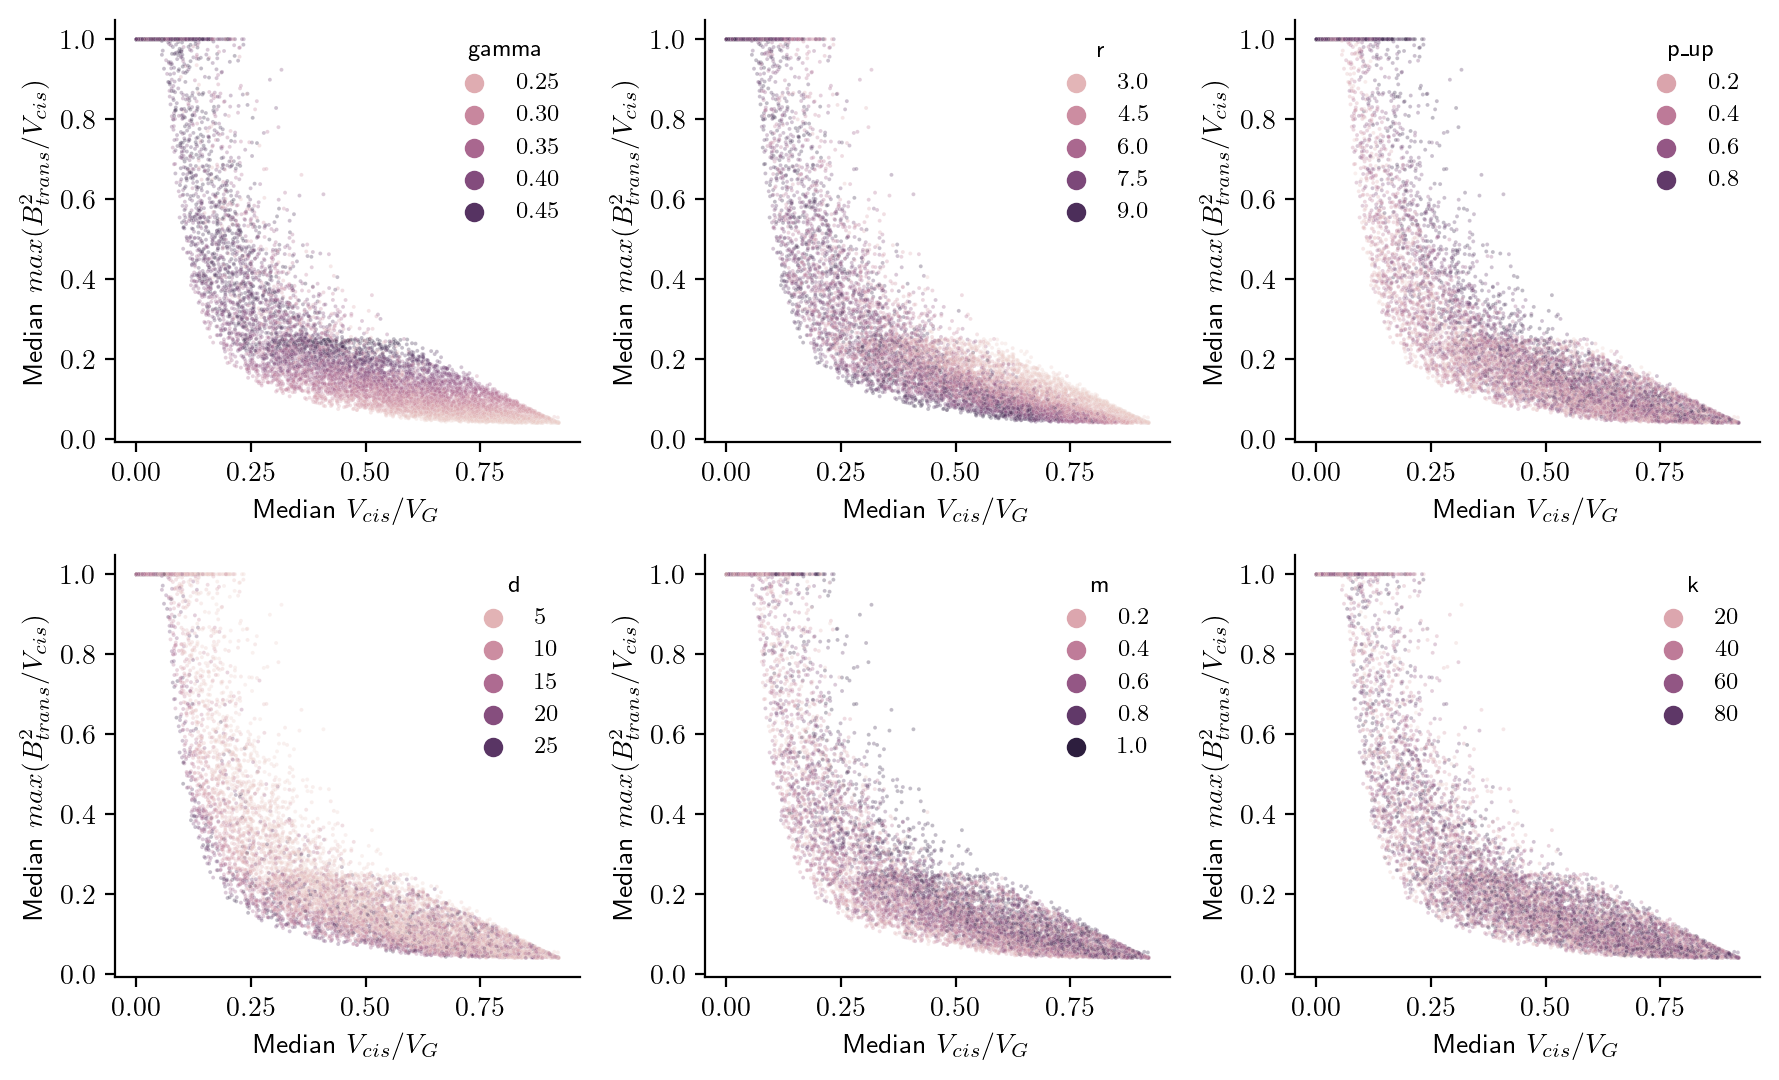

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(9, 5.5), dpi=200)

for (i,j), stat in zip([(i,j) for i in range(ax.shape[0]) for j in range(ax.shape[1])],
                       ['gamma', 'r', 'p_up', 'd', 'm', 'k']):
    sns.scatterplot(
        data = grns,
        x = 'Median $V_{cis}/V_{G}$',
        y = 'Median ' + r'$max(B_{trans}^2/V_{cis})$',
        hue = stat, 
        s=2,
        alpha=0.3,
        ax = ax[i,j]
    );
    
    ax[i,j].legend(
        fontsize = 'small', 
        title = stat, 
        title_fontsize = 'small', 
        frameon = False
    );

fig.tight_layout();
sns.despine()

## Match on the summary stats

In [8]:
grns['q1'] = grns['Median $V_{cis}/V_{G}$']
grns['q2'] = grns['Median ' + r'$max(B_{trans}^2/V_{cis})$']
grns['q3'] = grns['90Q ' + r'$max(B_{trans}^2/V_{cis})$']

query = '0.15 < q1 & q1 < 0.35 & 0.2 < q2 & q2 < 0.8'

ouwens = {
    'q1': h2[r'$h^2_{cis}/h^2$'].median(),
    'q2': h2[r'$\beta^2_{trans}$'].median() / h2[r'$\beta^2_{cis}$'].median(), 
    'q3': h2[r'$\beta^2_{trans}$'].quantile(0.6) / h2[r'$\beta^2_{cis}$'].median(), 
}

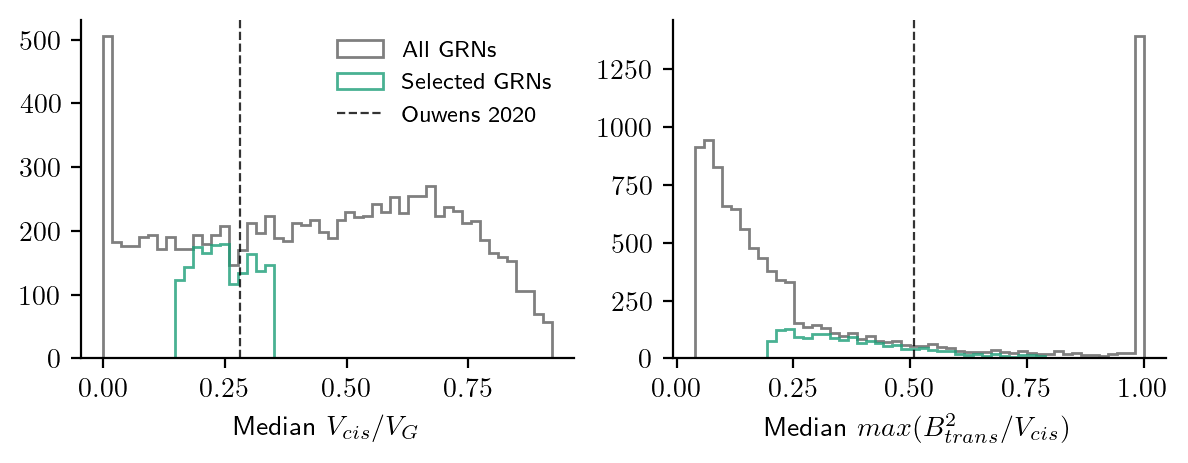

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.2), dpi=200)

for ix, par, label in zip(np.ndindex(axs.shape),
                                ['q1','q2'],
                                ['Median $V_{cis}/V_{G}$', 'Median ' + r'$max(B_{trans}^2/V_{cis})$']):
    ax = axs[ix]
    _, bins, _ = ax.hist(
        grns[par], 
        histtype='step', 
        bins = 50, 
        density=False, 
        alpha=0.5, 
        color='k', 
        label='All GRNs'
    );
    
    _ = ax.hist(
        grns.query(query)[par], 
        bins=bins, 
        histtype='step', 
        density=False, 
        alpha=0.8, 
        label='Selected GRNs'
    );
        
    ax.set_xlabel(label);     
    ax.axvline(
        ouwens[par], 
        linewidth=0.8, 
        color='k', 
        alpha=0.8, 
        linestyle='dashed', 
        label='Ouwens 2020'
    )
    
sns.despine()
axs[0].legend(fontsize='small', frameon=0)

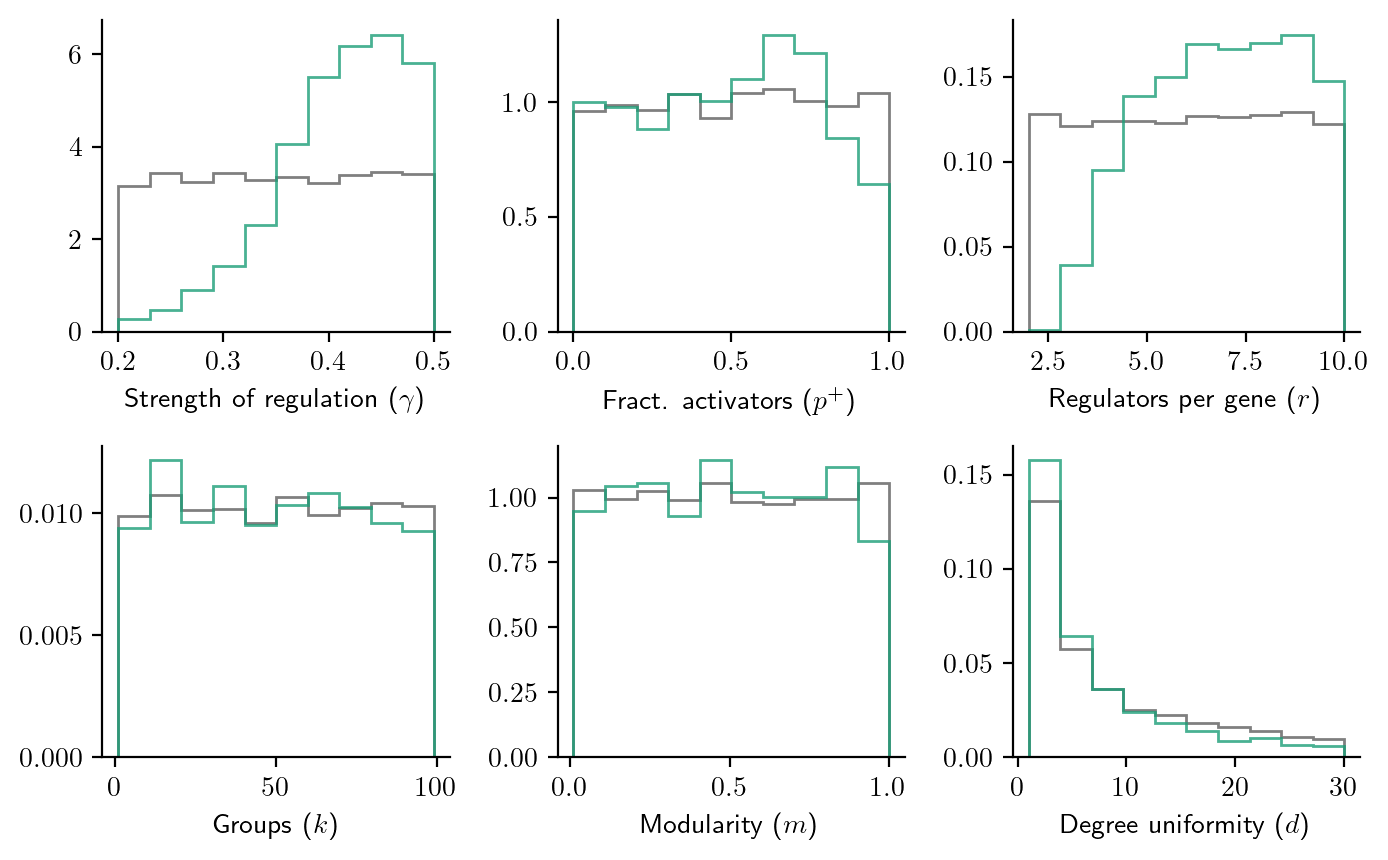

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['gamma','p_up','r','k','m','d'],
                                ['Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Degree uniformity ({})'.format(r'$d$')
                                 ]):
    if par == 'hier':
        continue
    else:
        _, bins, _ = axs[ix,iy].hist(grns.query('p_up > 0')[par], histtype='step', density=True, alpha=0.5, color='k');
        _ = axs[ix,iy].hist(grns.query(query)[par], bins=bins, histtype='step', density=True, alpha=0.8);
        
        axs[ix,iy].set_xlabel(label);
        
        
sns.despine();
plt.tight_layout();

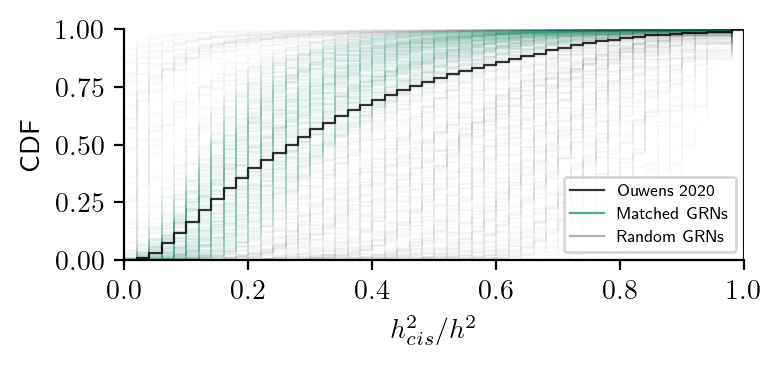

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4,1.5), dpi=200)


x_bins = np.linspace(0, 1, 51)



# random grns
for _,row in grns.sample(250).iterrows():
    # compute values
    x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])
    
    # plot
    ax.step(
        x_bins, 
        np.hstack([x, 0])/row.n, 
        where='post', 
        linewidth=0.1, 
        alpha=0.1, 
        color='k',
        label=None
    )


# good grns
for _,row in grns.query(query).sample(250).iterrows():
    # compute values
    x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])
    
    # plot
    ax.step(
        x_bins, 
        np.hstack([x, 0])/row.n, 
        where='post', 
        linewidth=0.1, 
        alpha=0.1, 
        color=plt.get_cmap('Dark2')(0),
        label=None
    )
                  
# ouwens
x = np.cumsum(np.histogram(h2.loc[h2['cis_eqtl_SNP'].notnull(), 'GCTA_Frac'], bins = x_bins)[0])


ax.step(
    x_bins, 
    np.hstack([x, 0])/h2['cis_eqtl_SNP'].notnull().sum(), 
    where='post', 
    color='k', 
    linewidth=0.8, 
    alpha=0.8,
    label='Ouwens 2020'
)



# fake legend
plt.plot(
    [], [],
    color=plt.get_cmap('Dark2')(0),
    linestyle='-',
    linewidth=0.8,
    marker='',
    alpha=0.8,
    label='Matched GRNs'
)

plt.plot(
    [], [],
    color='k',
    marker='',
    linestyle='-',
    linewidth=0.8,
    alpha=0.3,
    label='Random GRNs'
)



ax.set_xlim(0,1); 
ax.set_xlabel(r'$h^2_{cis} / h^2$');

ax.set_ylim(0,1);
ax.set_ylabel('CDF');
ax.legend(frameon=1, loc='lower right', fontsize=6);

sns.despine()

## Match on $h^2_{cis}$ distribution

In [12]:
grns[['ouwens_ks_stat','ouwens_ks_p']] = [ss.ks_2samp(v, ouwens_h2_cis, method='asymp')[:2] for v in grns['$V_{cis}/V_{G}$']]
grns[['ouwens_ks_stat','ouwens_ks_p']].describe()

,ouwens_ks_stat,ouwens_ks_p
count,10000.000000,1.000000e+04
mean,0.543513,6.274571e-06
std,0.235854,3.999194e-04
min,0.027345,0.000000e+00
25%,0.344400,0.000000e+00
50%,0.560464,0.000000e+00
75%,0.745842,7.974334e-287
max,0.988271,3.446576e-02


In [13]:
(grns['ouwens_ks_p'] > 0.05/grns.shape[0]).sum()

11

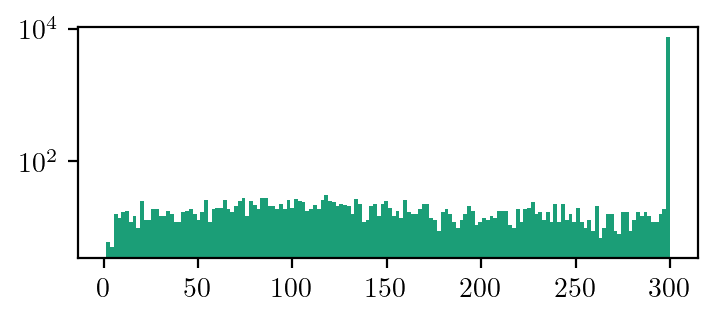

In [14]:
plt.subplots(1, 1, figsize=(4,1.5), dpi=200);

plt.hist(grns['ouwens_ks_p'].clip(lower=1e-300).apply(lambda x: -np.log10(x)), bins=150); plt.semilogy();

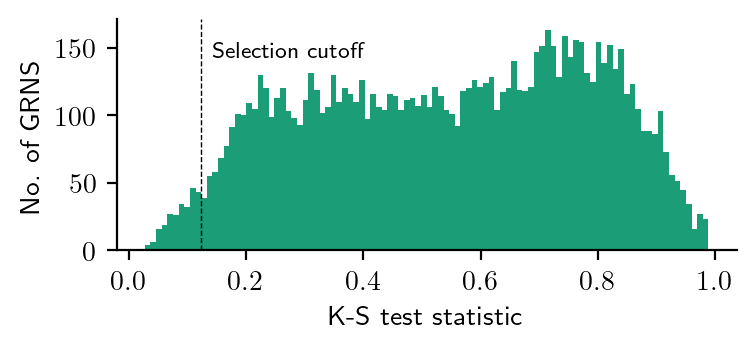

In [15]:
plt.subplots(1, 1, figsize=(4,1.5), dpi=200);

plt.hist(grns['ouwens_ks_stat'], bins=100); #plt.semilogy();

q_ks = grns['ouwens_ks_stat'].quantile(250/grns.shape[0])
plt.axvline(q_ks, linewidth=0.5, color='k', linestyle='--');

plt.xlabel('K-S test statistic');
plt.ylabel('No. of GRNS');
plt.text(q_ks + 0.02, 140, 'Selection cutoff', fontsize=8, ha='left', va='bottom');
sns.despine()

In [16]:
grns['selected'] = (grns['ouwens_ks_stat'] < grns['ouwens_ks_stat'].quantile(250/grns.shape[0]))

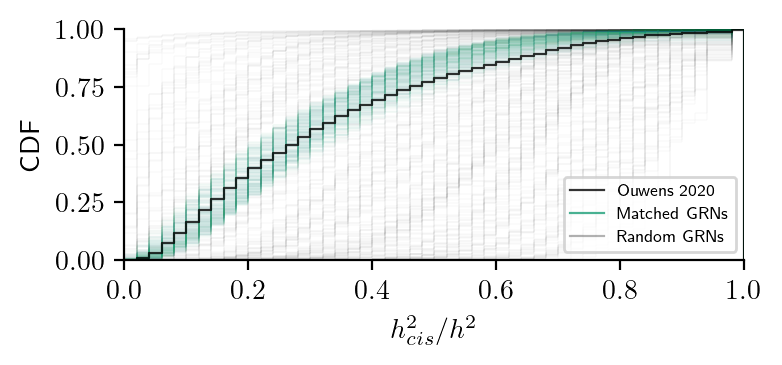

In [17]:
grns['selected'] = (grns['ouwens_ks_stat'] < grns['ouwens_ks_stat'].quantile(250/grns.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(4,1.5), dpi=200)


x_bins = np.linspace(0, 1, 51)



# random grns
for _,row in grns.query('~selected').sample(250).iterrows():
    # compute values
    x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])
    
    # plot
    ax.step(
        x_bins, 
        np.hstack([x, 0])/row.n, 
        where='post', 
        linewidth=0.1, 
        alpha=0.1, 
        color='k',
        label=None
    )


# good grns
for _,row in grns.query('selected').sample(250).iterrows():
    # compute values
    x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])
    
    # plot
    ax.step(
        x_bins, 
        np.hstack([x, 0])/row.n, 
        where='post', 
        linewidth=0.1, 
        alpha=0.1, 
        color=plt.get_cmap('Dark2')(0),
        label=None
    )
                  
# ouwens
x = np.cumsum(np.histogram(h2.loc[h2['cis_eqtl_SNP'].notnull(), 'GCTA_Frac'], bins = x_bins)[0])


ax.step(
    x_bins, 
    np.hstack([x, 0])/h2['cis_eqtl_SNP'].notnull().sum(), 
    where='post', 
    color='k', 
    linewidth=0.8, 
    alpha=0.8,
    label='Ouwens 2020'
)



# fake legend
plt.plot(
    [], [],
    color=plt.get_cmap('Dark2')(0),
    linestyle='-',
    linewidth=0.8,
    marker='',
    alpha=0.8,
    label='Matched GRNs'
)

plt.plot(
    [], [],
    color='k',
    marker='',
    linestyle='-',
    linewidth=0.8,
    alpha=0.3,
    label='Random GRNs'
)



ax.set_xlim(0,1); 
ax.set_xlabel(r'$h^2_{cis} / h^2$');

ax.set_ylim(0,1);
ax.set_ylabel('CDF');
ax.legend(frameon=1, loc='lower right', fontsize=6);

sns.despine()

In [18]:
grns.sort_values('ouwens_ks_stat', ascending=True).head(20)[['r','gamma','k','m','d','ouwens_ks_p']]

,r,gamma,k,m,d,ouwens_ks_p
8545,7.933735,0.293456,79,0.977510,4.119013,3.446576e-02
9223,7.923361,0.250051,53,0.932035,12.032948,1.967285e-02
1131,4.592218,0.338450,29,0.187455,5.320147,4.514729e-03
1371,3.248472,0.483725,32,0.168512,2.208115,1.510396e-03
7710,6.464606,0.422114,30,0.986631,1.407814,9.781178e-04
9115,8.842267,0.290658,79,0.942575,4.359007,9.707462e-04
3329,9.146470,0.280499,71,0.779592,2.540787,2.777824e-04
8904,5.590008,0.390910,80,0.759583,1.475541,1.396042e-04
9071,6.251650,0.338318,13,0.861579,1.998554,1.084865e-04
4551,8.574067,0.362616,94,0.899861,2.349546,8.659078e-05


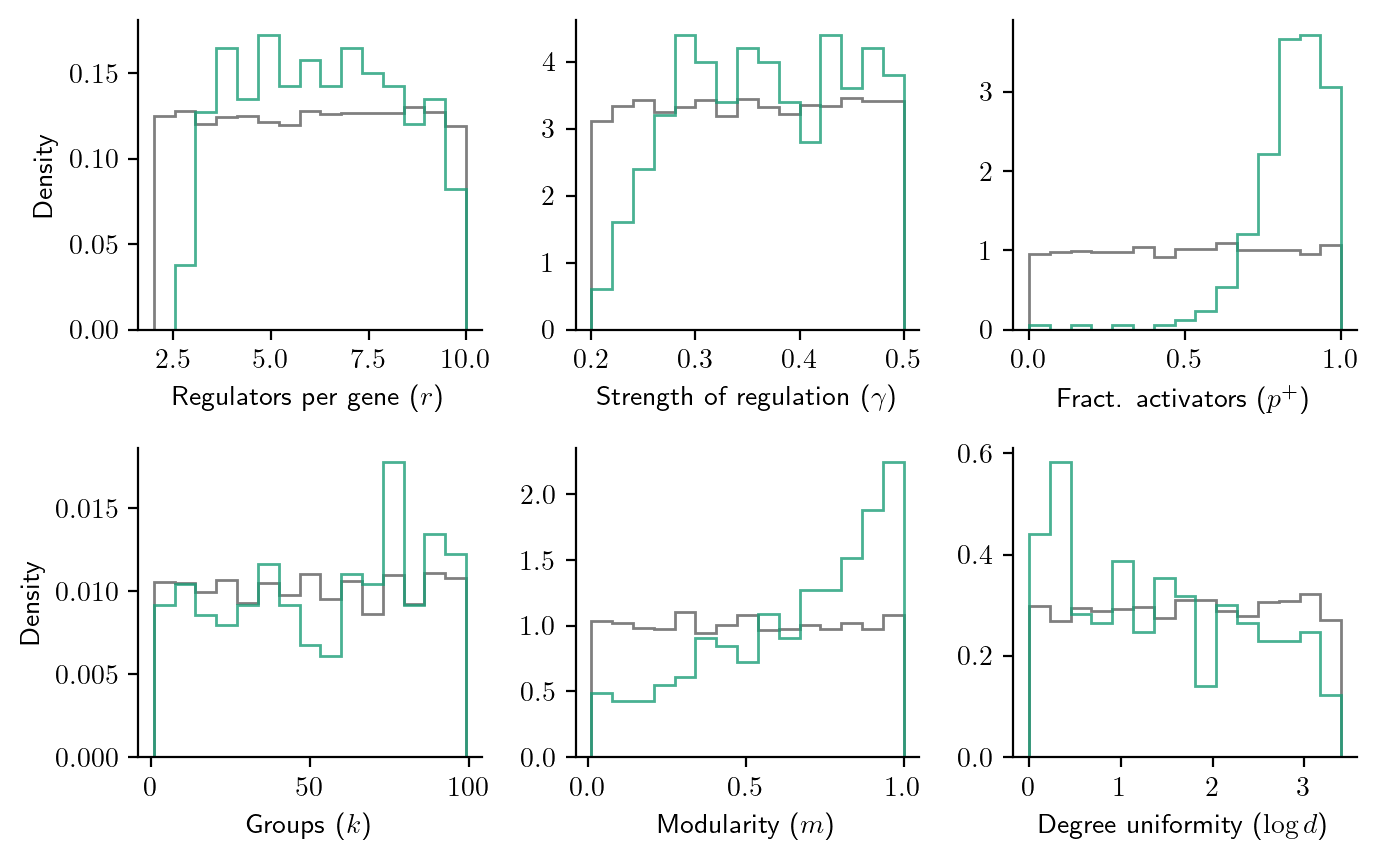

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), (par, label) in zip(np.ndindex(axs.shape),
                                  {
                                      'r': 'Regulators per gene ({})'.format(r'$r$'),
                                      'gamma': 'Strength of regulation ({})'.format(r'$\gamma$'),
                                      'p_up': 'Fract. activators ({})'.format(r'$p^+$'),
                                      'k': 'Groups ({})'.format(r'$k$'),
                                      'm': 'Modularity ({})'.format(r'$m$'),
                                      'log_d': 'Degree uniformity ({})'.format(r'$\log d$')
                                  }.items()
                                 ):
    ax = axs[ix,iy]
    # plot background
    _, bins, _ = ax.hist(
            grns[par], 
            histtype = 'step', 
            density = True, 
            alpha = 0.5, 
            color = 'k', 
            bins=15,
            label = 'All GRNs'
    );
    
    # plot selected
    _ = ax.hist(
            grns.sort_values('ouwens_ks_stat', ascending=True).head(250)[par], 
            bins = bins, 
            histtype = 'step', 
            density = True, 
            alpha = 0.8,
            label = 'Selected GRNs'
    );
    no='''
    sns.kdeplot(
        data = grns,
        x = par,
        color = 'k',
        alpha = 0.5,
        linewidth = 1,
        label = 'All GRNs',
        ax = ax
    );    
    
    sns.kdeplot(
        data = grns.sort_values('ouwens_ks_stat', ascending=True).head(250),
        x = par,
        alpha = 0.8,
        linewidth = 1,
        label = 'Selected GRNs',
        ax = ax
    );
    '''
        
    ax.set_xlabel(label);
    if par == 'd':
        ax.legend(frameon=False, fontsize=8, loc='upper right');
    if iy == 0:
        ax.set_ylabel('Density');
        
        
sns.despine();
plt.tight_layout();

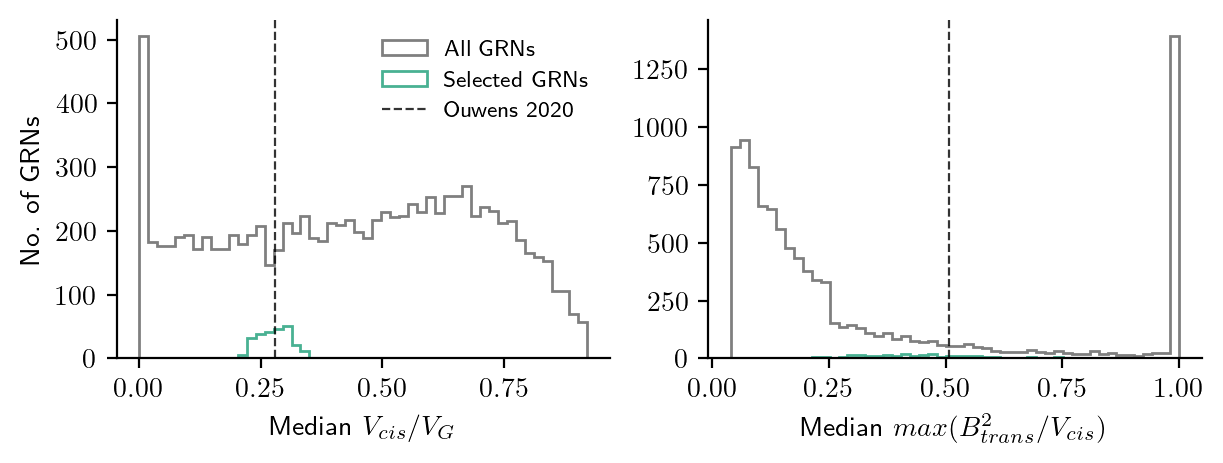

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(7, 2.2), dpi=200)

density = False

for ix, par, label in zip(np.ndindex(axs.shape),
                                ['q1','q2'],
                                ['Median $V_{cis}/V_{G}$', 'Median ' + r'$max(B_{trans}^2/V_{cis})$']):
    ax = axs[ix]
    # plot background
    _, bins, _ = ax.hist(
            grns[par], 
            histtype = 'step', 
            density = density, 
            alpha = 0.5, 
            color = 'k', 
            bins = 50,
            label = 'All GRNs'
    );
    
    # plot selected
    _ = ax.hist(
            grns.sort_values('ouwens_ks_stat', ascending=True).head(250)[par], 
            bins = bins, 
            histtype = 'step', 
            density = density, 
            alpha = 0.8,
            label = 'Selected GRNs'
    );
        
    ax.set_xlabel(label);  
    
    ax.axvline(
        ouwens[par], 
        linewidth=0.8, 
        color='k', 
        alpha=0.8, 
        linestyle='dashed', 
        label='Ouwens 2020'
    )
        
    if ix[0] == 0:
        ax.legend(fontsize=8, frameon=0);
        ax.set_ylabel('Density' if density else 'No. of GRNs');
    
sns.despine()

# Figure 5

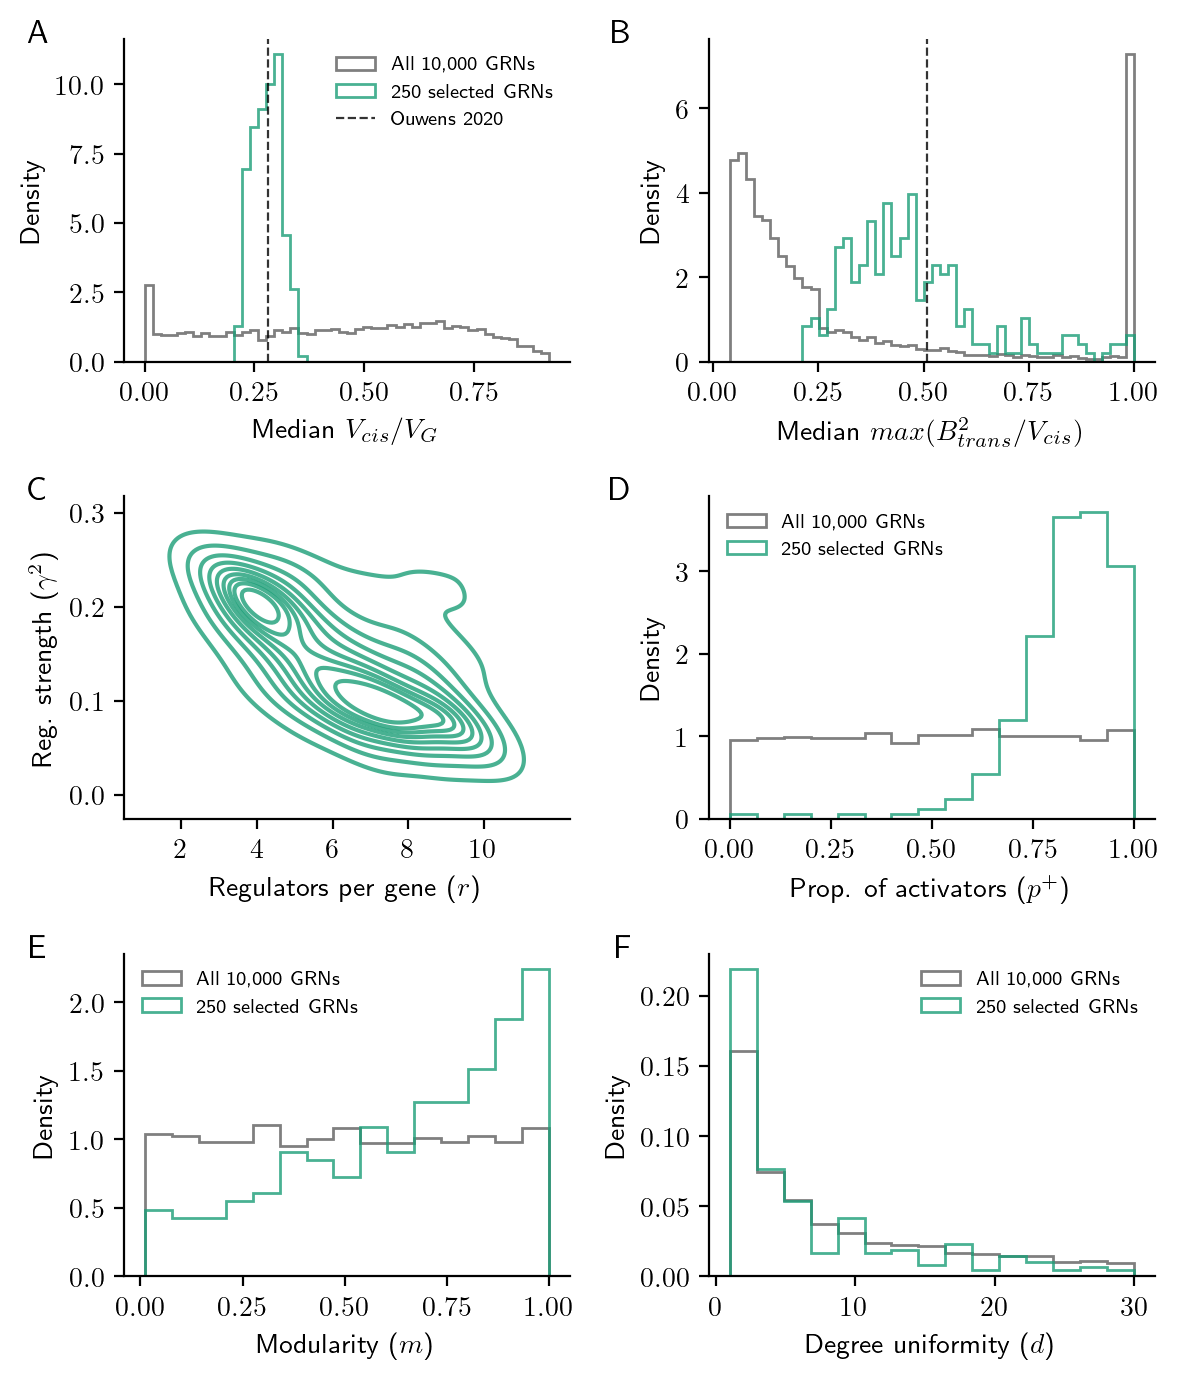

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(6, 7), dpi=200);

density = True
# Summary statistics
for ix, par, label in zip(range(axs.shape[1]),
                          ['q1','q2'],
                          ['Median $V_{cis}/V_{G}$', 'Median ' + r'$max(B_{trans}^2/V_{cis})$']
                         ):
    ax = axs[0,ix]
    # plot background
    _, bins, _ = ax.hist(
            grns[par], 
            histtype = 'step', 
            density = density, 
            alpha = 0.5, 
            color = 'k', 
            bins = 50,
            label = 'All 10,000 GRNs'
    );
    
    # plot selected
    _ = ax.hist(
            grns.sort_values('ouwens_ks_stat', ascending=True).head(250)[par], 
            bins = bins, 
            histtype = 'step', 
            density = density, 
            alpha = 0.8,
            label = '250 selected GRNs'
    );
        
    ax.set_xlabel(label);  
    
    ax.axvline(
        ouwens[par], 
        linewidth=0.8, 
        color='k', 
        alpha=0.8, 
        linestyle='dashed', 
        label='Ouwens 2020'
    )
    if ix == 0:    
        ax.legend(fontsize=7, frameon=0, loc='upper right' if par=='q1' else 'upper left');
    ax.set_ylabel('Density' if density else 'No. of GRNs');
    ax.text(-0.17, 0.97, 'AB'[ix], fontsize=12, ha='right', va='bottom', transform=ax.transAxes);
    

# Parameter diagrams

ax = axs[1,0]
grns['gamma2'] = grns['gamma'] ** 2

sns.kdeplot(
    grns.query('selected'), 
    y = 'gamma2', 
    x = 'r',
    hue = 'selected',
    alpha = 0.8,
    ax = ax
);
ax.legend(['250 selected GRNs'], frameon=0, fontsize=7, loc='upper right');
ax.set_xlabel('Regulators per gene ({})'.format(r'$r$'));
ax.set_xticks(range(2,11,2))
ax.set_ylabel('Reg. strength ({})'.format(r'$\gamma^2$'));
ax.text(-0.17, 0.97, 'C', fontsize=12, ha='right', va='bottom', transform=ax.transAxes);



for ix, (par, label),l2 in zip([(1,1),(2,0),(2,1)],
                                  {
                                      'p_up': 'Prop. of activators ({})'.format(r'$p^+$'),
                                      'm': 'Modularity ({})'.format(r'$m$'),
                                      'd': 'Degree uniformity ({})'.format(r'$d$')
                                  }.items(),
                                'DEF'
                                 ):
    ax = axs[ix] 
    # plot background
    _, bins, _ = ax.hist(
            grns[par], 
            histtype = 'step', 
            density = True, 
            alpha = 0.5, 
            color = 'k', 
            bins=15,
            label = 'All 10,000 GRNs'
    );
    
    # plot selected
    _ = ax.hist(
            grns.sort_values('ouwens_ks_stat', ascending=True).head(250)[par], 
            bins = bins, 
            histtype = 'step', 
            density = True, 
            alpha = 0.8,
            label = '250 selected GRNs'
    );
        
    ax.set_xlabel(label);
    ax.legend(frameon=False, fontsize=7, loc='upper right' if par == 'd' else 'upper left');
    ax.set_ylabel('Density');
    ax.text(-0.17, 0.97, l2, fontsize=12, ha='right', va='bottom', transform=ax.transAxes);
        

fig.tight_layout();
sns.despine();
plt.savefig('png/Figure5.png');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

0 0
1 1
2 2
0 3
1 4
2 0
0 1
1 2
2 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

0 4
1 0
2 1
0 2
1 3
2 4


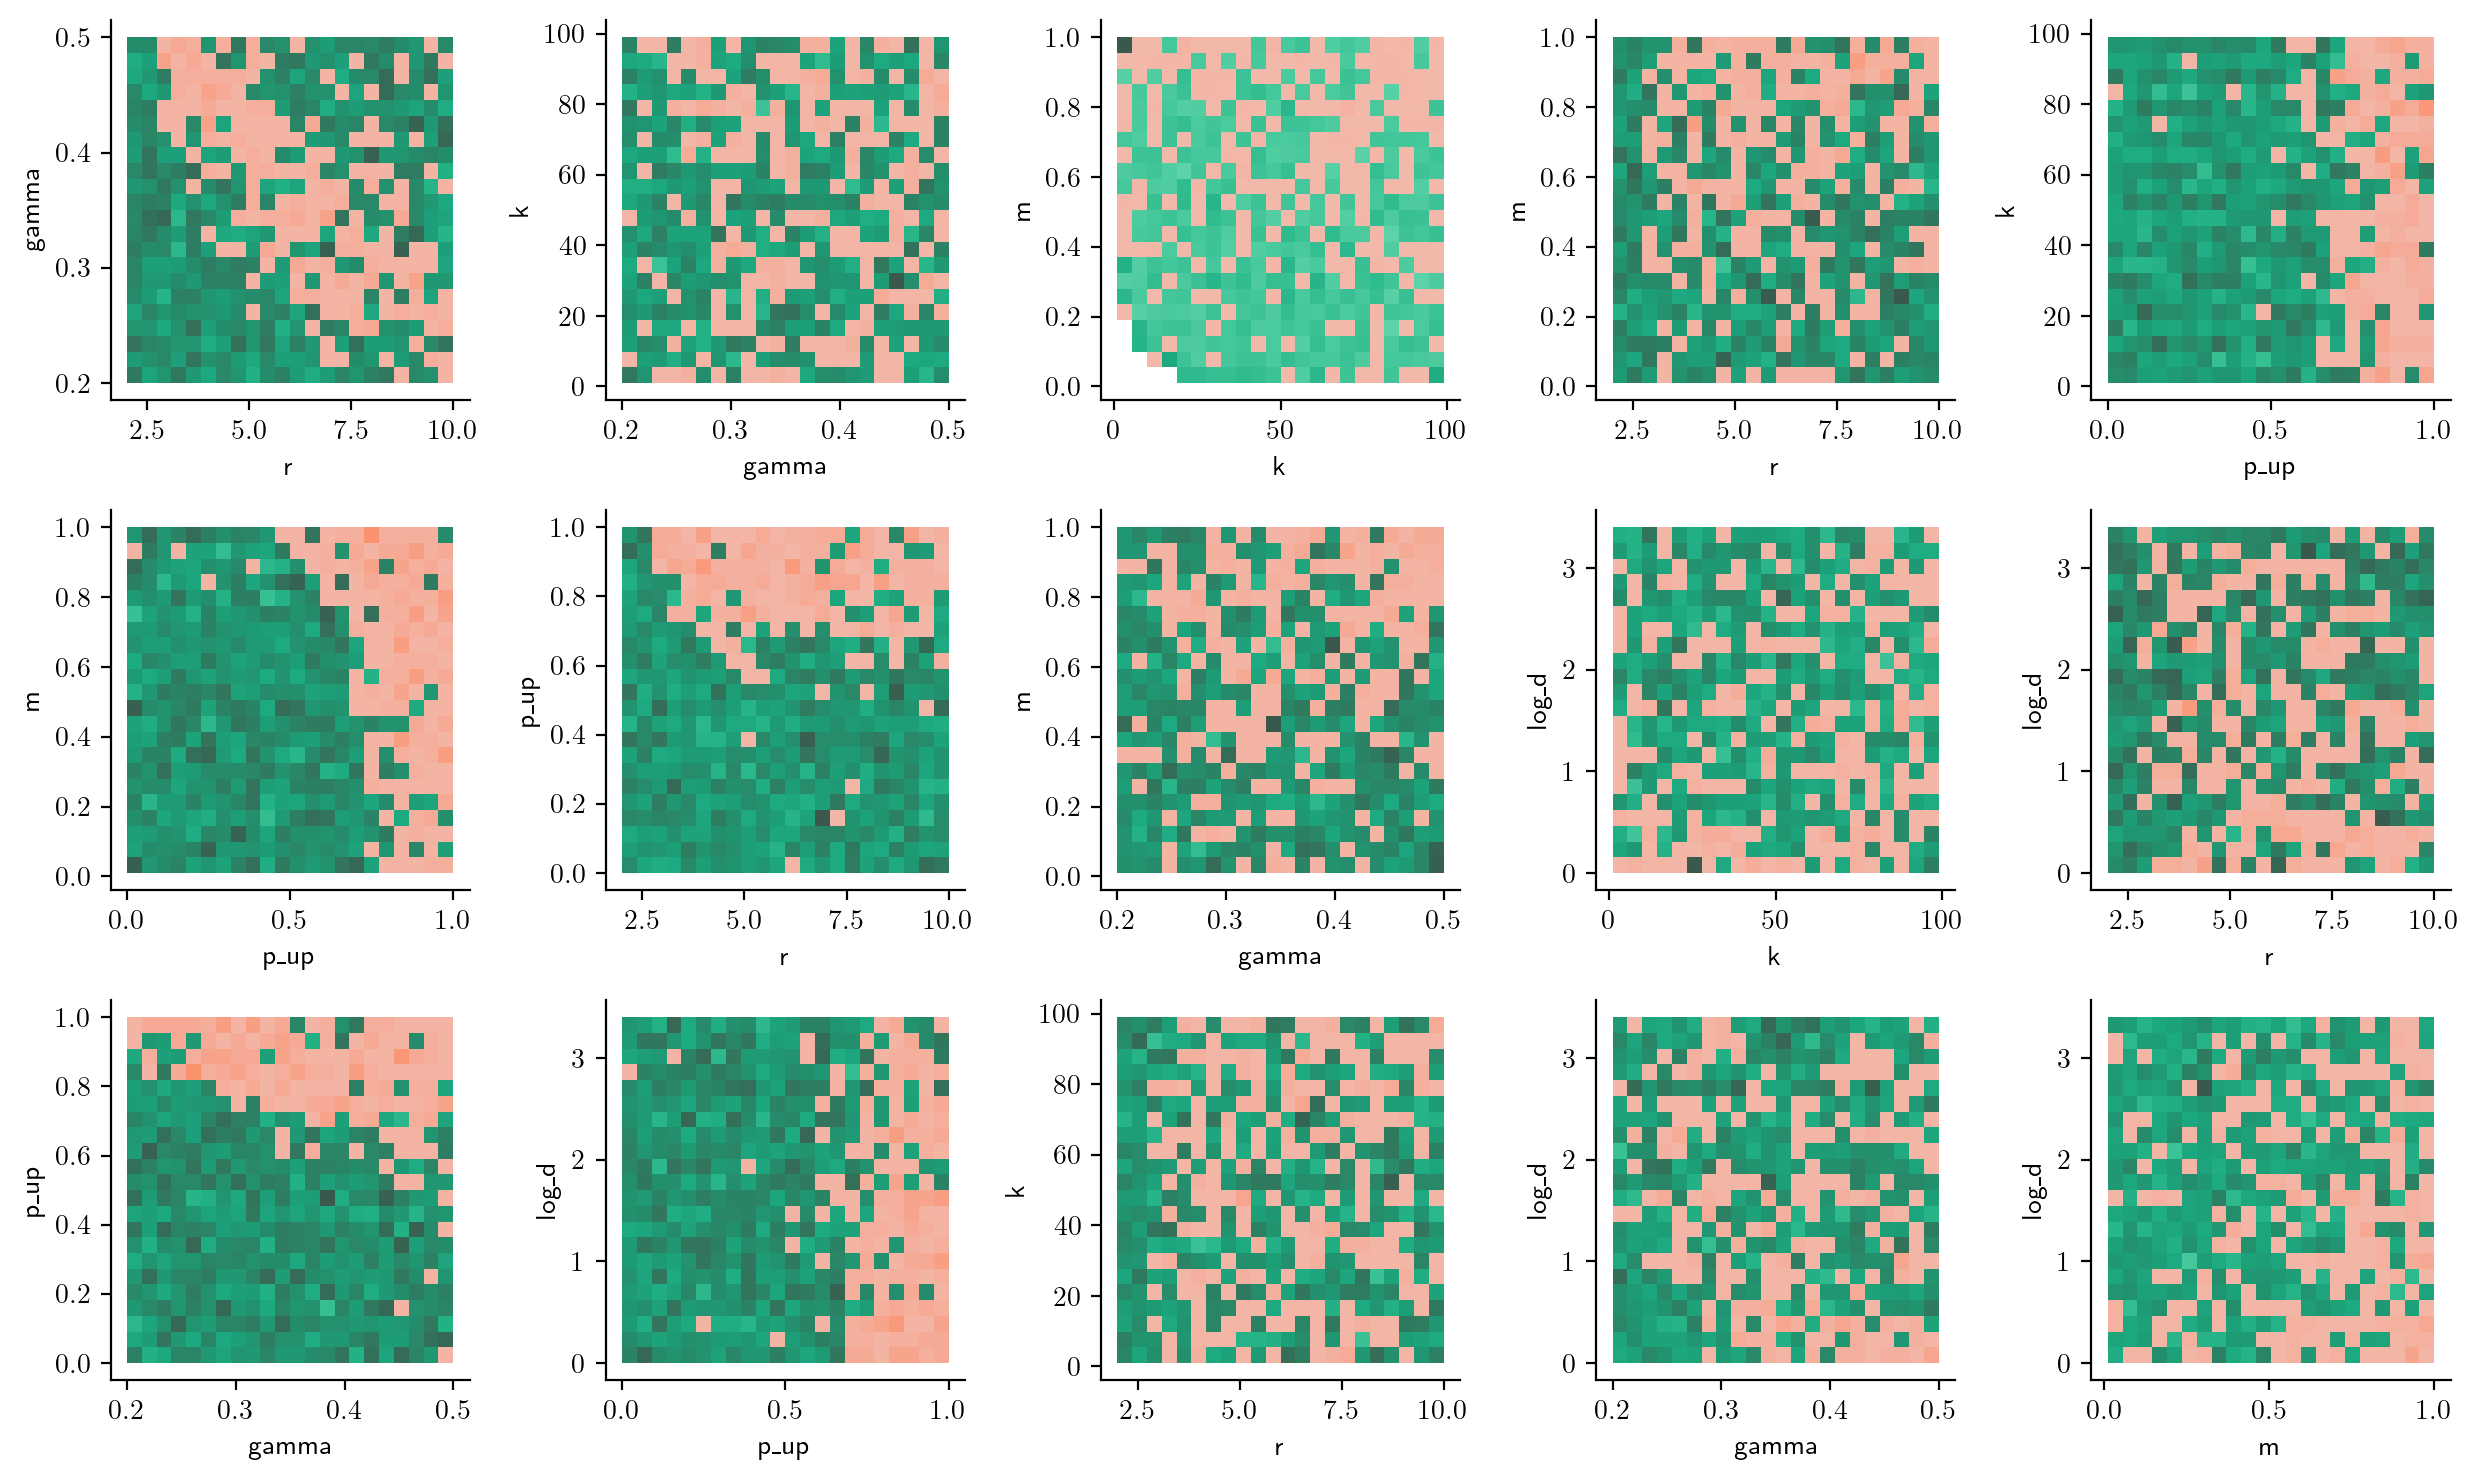

In [22]:
fig, axs = plt.subplots(3, 5, figsize=(2.5 * 5, 2.5 * 3), dpi=200);

for i,(x,y) in enumerate(itertools.combinations(['r','gamma','p_up','k','m','log_d'], 2)):
    ax = axs[i % axs.shape[0], i % axs.shape[1]]
    print(i % axs.shape[0], i % axs.shape[1])
    sns.histplot(
        grns, 
        x = x, 
        y = y,
        hue = 'selected',
        ax = ax
    );
    ax.legend(fontsize=6, loc='lower left', frameon=False);
    
fig.tight_layout();
sns.despine();
plt.show()

In [23]:
model_tri = sm.ols('np.log(triangles) ~ 1 + r + m + log_d', data = grns).fit()
model_dia = sm.ols('np.log(diamonds) ~ 1 + r + m + log_d', data = grns).fit()
grns['tri_resid'] = model_tri.resid
grns['dia_resid'] = model_dia.resid
print(model_tri.summary())
print(model_dia.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(triangles)   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 2.291e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:02:26   Log-Likelihood:                -7632.4
No. Observations:               10000   AIC:                         1.527e+04
Df Residuals:                    9996   BIC:                         1.530e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1313      0.019    263.360      0.0

# Supplement

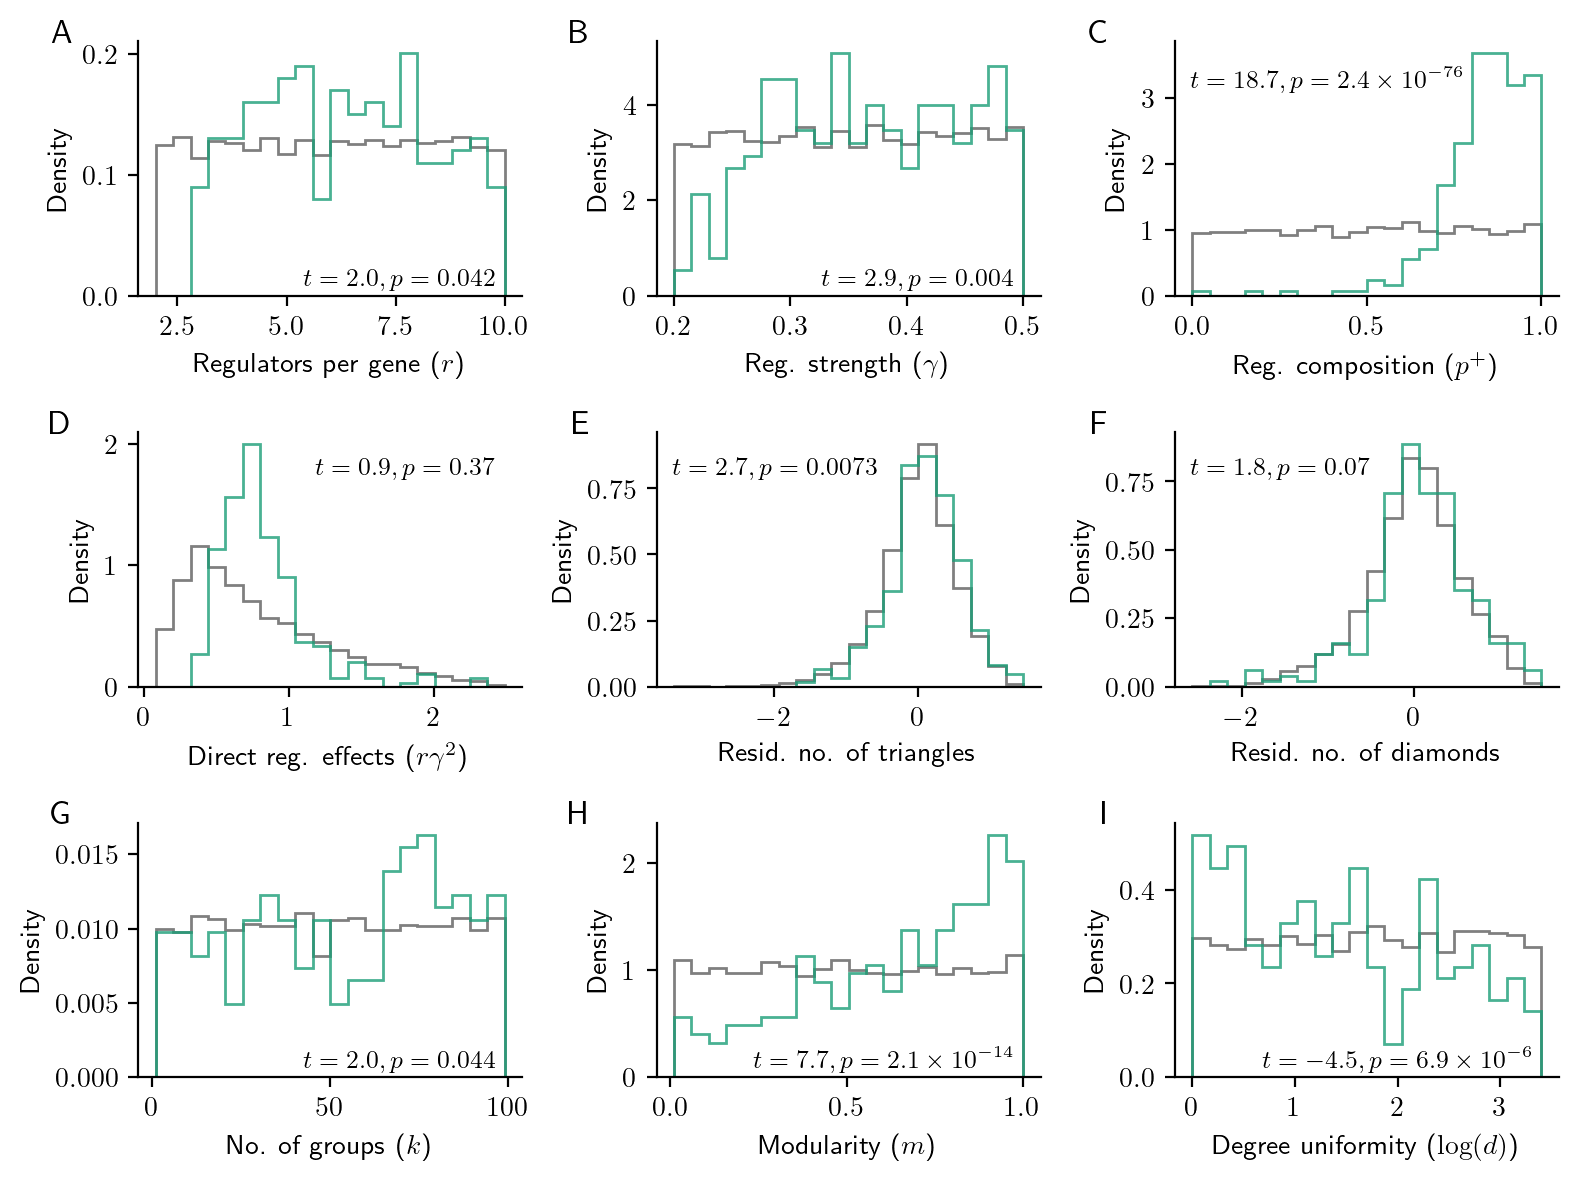

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=200);

for ix, (par, label),      letter in zip([(ix,iy) for ix in range(axs.shape[0]) for iy in range(axs.shape[1])],
                                         {
                                             'r': 'Regulators per gene ({})'.format(r'$r$'),
                                             'gamma': 'Reg. strength ({})'.format(r'$\gamma$'),
                                             'p_up': 'Reg. composition ({})'.format(r'$p^+$'),
                                             r'$r \gamma^2$': 'Direct reg. effects ({})'.format(r'$r \gamma^2$'),
                                             'tri_resid': 'Resid. no. of triangles',
                                             'dia_resid': 'Resid. no. of diamonds',
                                             'k': 'No. of groups ({})'.format(r'$k$'),
                                             'm': 'Modularity ({})'.format(r'$m$'),
                                             'log_d': 'Degree uniformity ({})'.format(r'$\log(d)$')
                                         }.items(),
                                       'ABCDEFGHI'
                                      ):
    ax = axs[ix]
    # plot background
    _, bins, _ = ax.hist(
            grns[par], 
            histtype = 'step', 
            density = True, 
            alpha = 0.5, 
            color = 'k', 
            bins=20,
            label = 'All GRNs'
    );
    
    # plot selected
    _ = ax.hist(
            grns.sort_values('ouwens_ks_stat', ascending=True).head(250)[par], 
            bins = bins, 
            histtype = 'step', 
            density = True, 
            alpha = 0.8,
            label = 'Selected GRNs'
    );
        
    ax.set_xlabel(label);
    ax.set_ylabel('Density');
    
    if par in ['p_up', r'$r \gamma^2$', 'tri_resid', 'dia_resid']:
        va = 'top'
        yy = 0.9
    else:
        va = 'bottom'
        yy = 0.02
    
    if par in ['p_up','tri_resid','dia_resid']:
        ha = 'left'
        xx = 0.04
    else:
        ha = 'right'
        xx = 0.93
    
    ax.text(
        xx, 
        yy,
        r'$t={0:.1f}, p=\num{{{1:.2g}}}$'.format(
            *ss.ttest_ind(
                grns.loc[grns.selected, par], 
                grns.loc[~grns.selected, par]
            )
        ),
        fontsize=9,
        transform=ax.transAxes,
        ha = ha, 
        va = va 
    );
    
    ax.text(-0.17, 0.97, letter, fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
        
fig.tight_layout();
sns.despine();
plt.savefig('png/supplement/Fig_S5B.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 669.32it/s]


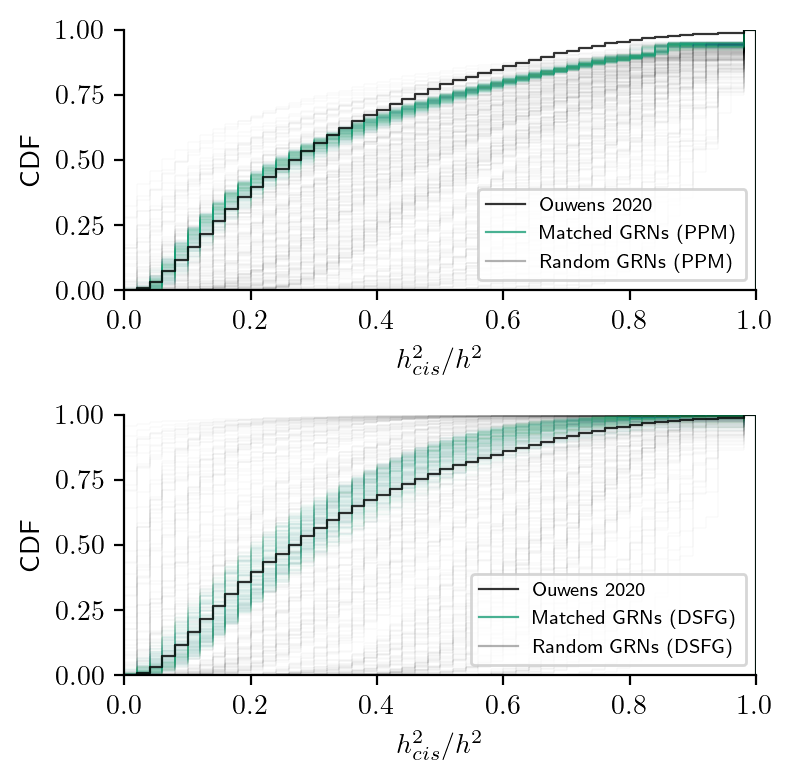

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(4,4), dpi=200)


for ix,nets in enumerate(['ppm','dsfg']):
    grns = pd.read_parquet('figdata/' + nets + '.graphs.parquet2')
    grns['Median '+r'$V_{cis}/V_{G}$'] = grns['Median '+r'$V_{cis}/V_{tot}$']
    grns[r'$V_{cis}/V_{G}$'] = grns[r'$V_{cis}/V_{tot}$']
    grns[['ouwens_ks_stat','ouwens_ks_p']] = [ss.ks_2samp(v, ouwens_h2_cis, method='asymp')[:2] for v in tqdm(grns['$V_{cis}/V_{G}$'])]
    
    grns['selected'] = (grns['ouwens_ks_stat'] < grns['ouwens_ks_stat'].quantile(250/grns.shape[0]))

    ax = axs[ix]

    x_bins = np.linspace(0, 1, 51)

    # random grns
    for _,row in grns.query('~selected').sample(250).iterrows():
        # compute values
        x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])

        # plot
        ax.step(
            x_bins, 
            np.hstack([x, 0])/row.n, 
            where='post', 
            linewidth=0.1, 
            alpha=0.1, 
            color='k',
            label=None
        )
    
    
    # good grns
    for _,row in grns.query('selected').sample(250).iterrows():
        # compute values
        x = np.cumsum(np.histogram(row['$V_{cis}/V_{G}$'], bins = x_bins)[0])

        # plot
        ax.step(
            x_bins, 
            np.hstack([x, 0])/row.n, 
            where='post', 
            linewidth=0.1, 
            alpha=0.1, 
            color=plt.get_cmap('Dark2')(0),
            label=None
        )
    
    # ouwens
    x = np.cumsum(np.histogram(h2.loc[h2['cis_eqtl_SNP'].notnull(), 'GCTA_Frac'], bins = x_bins)[0])
    
    ax.step(
        x_bins, 
        np.hstack([x, 0])/h2['cis_eqtl_SNP'].notnull().sum(), 
        where='post', 
        color='k', 
        linewidth=0.8, 
        alpha=0.8,
        label='Ouwens 2020'
    )
    
    # fake legend
    ax.plot(
        [], [],
        color=plt.get_cmap('Dark2')(0),
        linestyle='-',
        linewidth=0.8,
        marker='',
        alpha=0.8,
        label='Matched GRNs ({})'.format(nets.upper())
    )
    
    ax.plot(
        [], [],
        color='k',
        marker='',
        linestyle='-',
        linewidth=0.8,
        alpha=0.3,
        label='Random GRNs ({})'.format(nets.upper())
    )
    
    ax.set_xlim(0,1); 
    ax.set_xlabel(r'$h^2_{cis} / h^2$');

    ax.set_ylim(0,1);
    ax.set_ylabel('CDF');
    ax.legend(frameon=1, loc='lower right', fontsize=7);
    
    nah='''
    ax = axs[ix,1]
    ax.hist(grns['ouwens_ks_stat'], bins=100); #plt.semilogy();

    q_ks = grns['ouwens_ks_stat'].quantile(250/grns.shape[0])
    ax.axvline(q_ks, linewidth=0.5, color='k', linestyle='--');

    ax.set_xlabel('K-S test statistic');
    ax.set_ylabel('No. of GRNS');
    ax.text(q_ks + 0.02, 140, 'Selection cutoff', fontsize=7, ha='left', va='bottom');
    '''
    

sns.despine();
fig.tight_layout();
fig.savefig('png/supplement/Fig_S5A.png');